In [9]:
using PyPlot
p_ = PyPlot

PyPlot

### test out Distributions package

In [10]:
using Distributions
normal = Distributions.Normal(0., 1.0 )
Distributions.pdf(normal,1.5)
noisesigma = 0.1
noise = Distributions.Normal(0., noisesigma)
gaussian(val,μ,σ) = (1. /sqrt(2. * π * σ^2 )) * exp( - (val-μ)^2 / (2. * σ^2))
(gaussian(2.3,0,noisesigma), Distributions.pdf(noise,2.3))
(gaussian(-0.3,0,noisesigma), Distributions.pdf(noise,-0.3))   # same

(0.044318484119380115, 0.044318484119380115)

### model

A,B ~ N(0,1)

y = A x + B + \epsilon

### true parameter values

In [16]:
N = 5  # data points
A = randn()
B = randn()
(A,B)

(-0.6712765616772629, -0.14603001704769042)

### Generate sample data

In [17]:
ϵ = noisesigma * randn(N,)   # todo use Distributions package sample
x = 2. * randn(N,)
y = A * x .+ B .+ ϵ

5-element Array{Float64,1}:
  1.4419528830708923 
  1.3481759747319904 
 -1.8216983358841983 
  0.21393419323847113
 -0.7733298943204574 

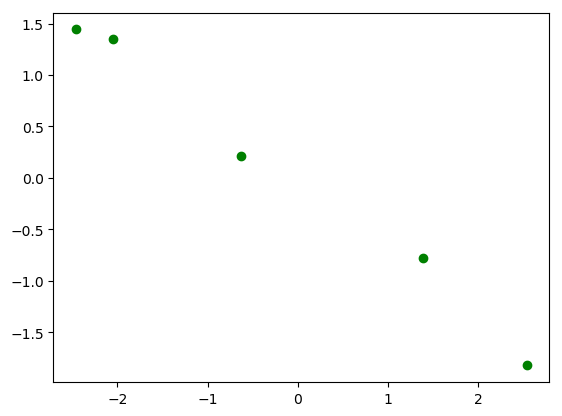

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x146125f28>

In [18]:
p_.plot(x,y,"go")

### Note likelihood (and improper prior) cancel
$$
    p(M|D) = \frac{ p(D|M) p(M)   }{ p(D)  } = \frac{ p(D|M) p(M)   }{ \int p(D|M) p(M) \, dM   }
$$

\begin{align*}
P(\theta|y,x) &= \frac{P(\theta,y,x)}{ P(y,x) }
\\
    &= \frac{ P(y|x,\theta) P(x|\theta) P(\theta) }{ P(y|x) P(x)  }
\\
    P(x|\theta) = P(x) \quad\text{and cancel}  &
\\
    &=  \frac{ P(y|x,\theta) P(\theta) }{ P(y|x) }
\\
\end{align*}

Posterior odds
\begin{align*}
   \frac{ P(\theta_1|y,x) }{ P(\theta|y,x) } &=   \frac{ \frac{ P(y|x,\theta_1) P(\theta_1) }{ P(y|x) } }{ \frac{ P(y|x,\theta) P(\theta) }{ P(y|x) } }     \quad=\quad  \frac{ P(y|x,\theta_1) P(\theta_1) }{  P(y|x,\theta) P(\theta)  }
\end{align*}

$$
    P(y|x,\theta) = \prod \frac{1}{\sqrt 2 \pi \sigma^2} \exp(- |y_i - (a x_i + b)|^2 / (2 \sigma^2)   
$$
log likelihood = 
$
  -\frac{N}{2}\log(2 \pi \sigma^2) \quad-\quad  \left( \sum |y_i - (a x_i + b)|^2 / (2\sigma^2) \right)   
$

(details)
\begin{align*}
&   \log \frac{1}{\sqrt{2 \pi \sigma^2}}
\\
&= \log 1  - \log ( 2 \pi \sigma^2 )^{1/2}
 \\
&=   0  - \frac{1}{2} \log{ 2 \pi \sigma^2}
\end{align*}

In [21]:
function loglikelihood(a,b)
    noisesigma2 = noisesigma*noisesigma
    ll = 0.
    for ipt = 1:N
        #print("  datapoint $ipt ")
        err = y[ipt] - (a*x[ipt]+b)
        peval = err*err / (2*noisesigma2)
        #print(" p0eval=",peval)
        ll -= peval
    end 
    ll -= (N/2.)*log(2*π*noisesigma2)
    ll
end

loglikelihood (generic function with 1 method)

In [22]:
function logposterior(a,b)
    useprior = false   # else improper/flat prior
    prior = 0.
    if useprior
        prior -= Distributions.pdf(normal,a)
        prior -= Distributions.pdf(normal,b)
    end
    prior + loglikelihood(a,b)
end

logposterior (generic function with 1 method)

Stopping test, log version

$\frac{ \exp(n)}{\exp(d)} > 1  \quad\rightarrow\quad   n - d > 0 $

In [23]:
function mcmc1logposterior(a,b)
    println("mcmc1logposterior initial $a $b")
    
    logposterior0 = logposterior(a,b)
    
    for mciter = 1:100
        if ((mciter%10)==0) println("  mciter $mciter")  end
        a_ = a + 0.5 * randn()
        b_ = b + 0.5 * randn()       # new proposal
        
        logposterior1 = logposterior(a_,b_)
        
        #println("logp1 $logposterior1,   logp0 $logposterior0")

        p = exp(logposterior1) / exp(logposterior0)
        if (rand() < p)
            println("\nsuccess $a_, $b_")
            return (a_,b_)
        else
            print(".")
        end   
    end
    println("")
    return (a,b)
end

mcmc1logposterior (generic function with 1 method)

In [24]:
function warmup(a,b) 
    for iter = 1:1000 
        if ((iter%10)==0) println("iter $iter")  end
        a,b = mcmc1logposterior(a,b)   
    end
    return (a,b)
end                # warmup


warmup (generic function with 1 method)

In [25]:
function mcmcline(a,b)
    aavg, bavg = (0.,0.)
    Niter = 100000
    for iter = 1:Niter 
        if ((iter%10)==0) println("iter $iter")  end
        a,b = mcmc1logposterior(a,b)   
        aavg += a
        bavg += b
    end
    aavg /= float(Niter)
    bavg /= float(Niter)
    return (aavg,bavg)
end

mcmcline (generic function with 1 method)

In [26]:
# initial posterior estimate
a_, b_ = 0.,0.

a_, b_ = warmup(a_,b_)
aest, best = mcmcline(a_,b_)

print("estimate $aest, $best,   true $A, $B")

mcmc1logposterior initial 0.0 0.0

success -0.2663575811598203, -0.43521915072337775
mcmc1logposterior initial -0.2663575811598203 -0.43521915072337775

success -0.9137514121410659, -0.15219207117947103
mcmc1logposterior initial -0.9137514121410659 -0.15219207117947103

success -0.6842282603007186, -0.23299257420295338
mcmc1logposterior initial -0.6842282603007186 -0.23299257420295338
.........  mciter 10
..........  mciter 20
........
success -0.6106621547271328, -0.008710204286395629
mcmc1logposterior initial -0.6106621547271328 -0.008710204286395629
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
........
success -0.6067367617174082, -0.044525044320629974
mcmc1logposterior initial -0.6067367617174082 -0.044525044320629974
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
.........
success -0.6081024704033658, -0.07737238872252188
mcmc1logposterior initial -0.6081024704033658 -0.07737238872252188
.........  m

.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6310471628644923 -0.07796132322991609
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
......
success -0.6343878829007494, -0.03252682977713664
mcmc1logposterior initial -0.6343878829007494 -0.03252682977713664
....
success -0.6500483132978835, -0.09217277899769463
mcmc1logposterior initial -0.6500483132978835 -0.09217277899769463
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6500483132978835 -0.09217277899769463
.........  mciter 10
..........  mciter 20
..........  mciter 30
..

..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6668085976012814 -0.1415492595678899
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..
success -0.6632116505332436, -0.17772152590880191
mcmc1logposterior initial -0.6632116505332436 -0.17772152590880191
.........  mciter 10
........
success -0.6155557795265633, 0.04223169744179117
mcmc1logposterior initial -0.6155557795265633 0.04223169744179117
.........  mciter 10
..
success -0.6371034790042985, -0.020943313587668544
mcmc1logposterior initial -0.6371034790042985 -0.020943313587668544
.........  mciter 10
...
success -0.6184685106415433, -0.0005009012807858371
mcmc1logposterior initial -0.6184685106415433 -0.0005009012807858371
.........  mciter 10

success -0.6665645628848887, -0.011905445691386358
mcmc1logposterior i

.........  mciter 10
..........  mciter 20
.......
success -0.6368753133849594, -0.11224772694740567
mcmc1logposterior initial -0.6368753133849594 -0.11224772694740567
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6368753133849594 -0.11224772694740567
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6368753133849594 -0.11224772694740567
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.636

mcmc1logposterior initial -0.6470729397138835 -0.006727149062050977
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6470729397138835 -0.006727149062050977
.
success -0.6457226172434345, -0.11863082249546071
mcmc1logposterior initial -0.6457226172434345 -0.11863082249546071
.........  mciter 10
..........  mciter 20
.........
success -0.6608406620516541, -0.15503180499880423
mcmc1logposterior initial -0.6608406620516541 -0.15503180499880423
.........  mciter 10
..........  mciter 20

success -0.6739584403952351, -0.14493332723156876
iter 210
mcmc1logposterior initial -0.6739584403952351 -0.14493332723156876
.........  mciter 10
..........  mciter 20
.........
success -0.6812274694425724, -0.052064441106756454
mcmc1logposterior initial -0.6812274694425724 -0.052064441106756454
.........  

..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6444312835513257 -0.08612038686976048
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6444312835513257 -0.08612038686976048
.........  mciter 10
..........  mciter 20
....
success -0.6535793345884903, -0.11052275993334071
mcmc1logposterior initial -0.6535793345884903 -0.11052275993334071
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6535793345884903 -0.11052275993334071
.........  mciter 10
..........  mciter 20
..........  mciter 30

success -0.6551506446200175, -0.2153853278368012
mcmc1l

..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6285170494343763 -0.09713310053187593
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6285170494343763 -0.09713310053187593
.........  mciter 10
..........  mciter 20
.........
success -0.6110474592651451, -0.16404548410897646
mcmc1logposterior initial -0.6110474592651451 -0.16404548410897646
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80

success -0.6487156057005381, -0.2085242716305335
mcmc1logposterior initial -0.6487156057005381 -0.2085242716305335
.........  mciter 10
..........  mciter 20
.....
success -0.6211678180912817, -0.026302456730188772
iter 320
mcmc1logposterior initial -

..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 360
mcmc1logposterior initial -0.6631499205545175 -0.07082068838567124
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6631499205545175 -0.07082068838567124
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6631499205545175 -0.07082068838567124
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mc

success -0.6370806252339848, -0.101565520408095
mcmc1logposterior initial -0.6370806252339848 -0.101565520408095
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6370806252339848 -0.101565520408095
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 400
mcmc1logposterior initial -0.6370806252339848 -0.101565520408095
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6370806252339848 -0.101565520408095
.........  mciter

..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6518421104888471 -0.08303989402085064
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6518421104888471 -0.08303989402085064
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6518421104888471 -0.08303989402085064
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
.

..........  mciter 40
.....
success -0.6283711733800962, -0.07612290957607608
mcmc1logposterior initial -0.6283711733800962 -0.07612290957607608
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6283711733800962 -0.07612290957607608
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6283711733800962 -0.07612290957607608
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6283711733800962 -0.076122

mcmc1logposterior initial -0.6417176225255531 -0.024210812647716254
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6417176225255531 -0.024210812647716254
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6417176225255531 -0.024210812647716254
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6417176225255531 -0.024210812647716254
.........  mciter 10
..........  mciter 20
..........  mciter 

.......
success -0.6486617040467563, -0.0415538575593308
mcmc1logposterior initial -0.6486617040467563 -0.0415538575593308
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6486617040467563 -0.0415538575593308
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6486617040467563 -0.0415538575593308
.........  mciter 10
..........  mciter 20
..........  mciter 30
.........
success -0.6304733891369159, -0.050460158075471315
mcmc1logposterior initial -0.6304733891369159 -0.050460158075471315
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 5

.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6445299191966357 -0.16986027298356776
.........  mciter 10
..........  mciter 20
..........  mciter 30
........
success -0.6849943169031979, -0.06925927207025033
mcmc1logposterior initial -0.6849943169031979 -0.06925927207025033
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
.....
success -0.6124076823490666, -0.036086577826115136
mcmc1logposterior initial -0.6124076823490666 -0.036086577826115136
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70

success -0.6505786657221416, -0.0963082116459924
mcmc1logposterior initial -0.6505786657221416 -0.0963082116459924
.........  mciter

mcmc1logposterior initial -0.6667211171068969 -0.13317340289547286
.........  mciter 10
..........  mciter 20
..........  mciter 30
.......
success -0.6762928335195043, -0.03224727897583239
mcmc1logposterior initial -0.6762928335195043 -0.03224727897583239
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6762928335195043 -0.03224727897583239
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
.
success -0.6344450849276119, -0.03268680166039377
mcmc1logposterior initial -0.6344450849276119 -0.03268680166039377
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial 

mcmc1logposterior initial -0.6748504146536938 -0.12204117801983477
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
....
success -0.6396731624626631, -0.07427641727748444
mcmc1logposterior initial -0.6396731624626631 -0.07427641727748444
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6396731624626631 -0.07427641727748444
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6396731624626631 -0.07427641727748444
.........  mciter 10
..........  mci

..........  mciter 90
..........  mciter 100
.
iter 780
mcmc1logposterior initial -0.6223370322181626 -0.13568337366404723
.........  mciter 10
...
success -0.6236170187594409, 0.01814159291540543
mcmc1logposterior initial -0.6236170187594409 0.01814159291540543
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
....
success -0.5982487515431747, -0.1192162076053559
mcmc1logposterior initial -0.5982487515431747 -0.1192162076053559
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.5982487515431747 -0.1192162076053559
.........  mciter 10
..........  mciter 20
..........  mciter 30
....
success -0.6918815733011396, 0.0027542274095327945
mcmc1logposterior initial -0.6918815733011396 0.0027542274095327945
.........

success -0.676136919909837, -0.0881567863842928
mcmc1logposterior initial -0.676136919909837 -0.0881567863842928
.......
success -0.6795946978987616, -0.03205239287190913
mcmc1logposterior initial -0.6795946978987616 -0.03205239287190913
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
...
success -0.6241161183027737, -0.09167013856424147
mcmc1logposterior initial -0.6241161183027737 -0.09167013856424147
.........  mciter 10
..
success -0.7090079731238188, -0.03962085096518371
mcmc1logposterior initial -0.7090079731238188 -0.03962085096518371
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7090079731238188 -0.03962085096518371
.........  mciter 10
..........  mci

iter 870
mcmc1logposterior initial -0.5902088195714856 -0.06436070444327219
.........  mciter 10
..........  mciter 20
.....
success -0.6836651013885676, -0.15735989335915151
mcmc1logposterior initial -0.6836651013885676 -0.15735989335915151
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
.
success -0.6428375280895672, 0.09083583426359962
mcmc1logposterior initial -0.6428375280895672 0.09083583426359962
.
success -0.5513059139701821, -0.07857361648193936
mcmc1logposterior initial -0.5513059139701821 -0.07857361648193936
.......
success -0.6415584844618464, -0.049698110628770886
mcmc1logposterior initial -0.6415584844618464 -0.049698110628770886
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6415584844618464 -0.049698110628770

..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6454538656402792 -0.035574815135927196
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6454538656402792 -0.035574815135927196
.......
success -0.6762703594167523, -0.1060034422007163
mcmc1logposterior initial -0.6762703594167523 -0.1060034422007163
.........  mciter 10
..........  mciter 20
....
success -0.6174472396749339, -0.03877298272824471
mcmc1logposterior initial -0.6174472396749339 -0.03877298272824471
.........  mciter 10
..........  mciter 20
........
success -0.6737508327826728, -0.008337888367050007
mcmc1logposterior initial -0.6737508327826728 -0.008337888367050007
....

..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90

success -0.6204823340996297, -0.11303392567591843
mcmc1logposterior initial -0.6204823340996297 -0.11303392567591843
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
........
success -0.6148115048800851, -0.04703175514231435
mcmc1logposterior initial -0.6148115048800851 -0.04703175514231435
.........  mciter 10
.....
success -0.6583800459843449, -0.11464935949913288
mcmc1logposterior initial -0.6583800459843449 -0.11464935949913288
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6583800459843449 -0.11464935949913288
.........  mciter 10
...
success -0.649472880680328, -0.009320740136915029
mcmc1logposterior initial -0.649472880680328 -0.009

.........  mciter 10
..........  mciter 20
..........  mciter 30
.......
success -0.6469588625440604, -0.06876612852971098
mcmc1logposterior initial -0.6469588625440604 -0.06876612852971098
...
success -0.6285736136126261, -0.062071206553967105
mcmc1logposterior initial -0.6285736136126261 -0.062071206553967105
...
success -0.641141138637326, 0.052360351212026875
mcmc1logposterior initial -0.641141138637326 0.052360351212026875
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
...
success -0.6164759592183143, -0.0916726413838608
mcmc1logposterior initial -0.6164759592183143 -0.0916726413838608
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 1000
mcmc1logposterior in

.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60

success -0.6997361248788704, -0.09090140556971633
mcmc1logposterior initial -0.6997361248788704 -0.09090140556971633
.........  mciter 10
..........  mciter 20
..........  mciter 30
........
success -0.666302429802546, -0.17922081426952852
iter 70
mcmc1logposterior initial -0.666302429802546 -0.17922081426952852
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
.........
success -0.6739527210290165, -0.08220362385405214
mcmc1logposterior initial -0.6739527210290165 -0.08220362385405214
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6739527210290165 -0.08220362385405214
.........  mciter 10
........

..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
.
success -0.649965668525898, -0.06912348969992753
mcmc1logposterior initial -0.649965668525898 -0.06912348969992753
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 140
mcmc1logposterior initial -0.649965668525898 -0.06912348969992753
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
........
success -0.6447418630036924, -0.043379826199317115
mcmc1logposterior initial -0.6447418630036924 -0.043379826199317115
.........  mciter 10
..........  mciter 20
.....
success -0.6552309586121178, -0.09826373120952275
mcmc1logposterior initial -0.6552309586121178 -0.09826373120952275
.........  mciter 10
..........  mciter 20
....
suc

..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 180
mcmc1logposterior initial -0.7190496689381966 -0.13074284331485872
.........  mciter 10
..........  mciter 20
..........  mciter 30

success -0.596231163495994, -0.17435062752974348
mcmc1logposterior initial -0.596231163495994 -0.17435062752974348
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.596231163495994 -0.17435062752974348
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
.......
success -0.6592936510646505, 0.04282028783156816
mcmc1logposterior initial -0.6592936510646505 0.04282028783156816
.........  mciter 10
..........  mciter 20

success -0.6803323487648433, -0.18425024986531502
mcmc1logposterior initial -0.680332348

..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6024148562748545 -0.06427770167993035
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6024148562748545 -0.06427770167993035
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6024148562748545 -0.06427770167993035
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70



..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6338783971019576 -0.1261655091964891
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6338783971019576 -0.1261655091964891
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6338783971019576 -0.1261655091964891
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.
success -0.6675478379788594, -0.0812065830352397
mcmc1logposterior initial -0.6675478379788594 -0.08120658303523

......
success -0.6327854960405364, -0.0014905450155438538
mcmc1logposterior initial -0.6327854960405364 -0.0014905450155438538
.........  mciter 10
..........  mciter 20
..........  mciter 30
......
success -0.5977054392884739, -0.0817954703952403
mcmc1logposterior initial -0.5977054392884739 -0.0817954703952403
.........  mciter 10
..........  mciter 20
..........  mciter 30
.........
success -0.6193831768778228, -0.057591245896304065
mcmc1logposterior initial -0.6193831768778228 -0.057591245896304065
.........  mciter 10
.....
success -0.6110092531554272, -0.07844217369382639
mcmc1logposterior initial -0.6110092531554272 -0.07844217369382639
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
........
success -0.644603208211068, -0.0502620143220396
iter 330
mcmc1logposterior initial -0.644603208211068 -0.0502620143220396
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 5

..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6333196506820474 -0.13648248566846144
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6333196506820474 -0.13648248566846144
.........  mciter 10
..........  mciter 20
..........  mciter 30
........
success -0.6215287968971683, -0.01852286927949251
mcmc1logposterior initial -0.6215287968971683 -0.01852286927949251
.........  mciter 10
..........  mciter 20
...
success -0.6512717862596141, -0.07354047509090121
mcmc1logposterior initial -0.6512717862596141 -0.07354047509090121
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
.

..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6550187377749572 -0.09320830114110729
.........  mciter 10
..........  mciter 20
...
success -0.6057946602020342, -0.10044247149511391
mcmc1logposterior initial -0.6057946602020342 -0.10044247149511391
.........  mciter 10
......
success -0.6503753976155848, -0.15673389812574307
mcmc1logposterior initial -0.6503753976155848 -0.15673389812574307
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6503753976155848 -0.15673389812574307
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
...

..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6321105437601894 -0.09283774999195518
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6321105437601894 -0.09283774999195518
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6321105437601894 -0.09283774999195518
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior in

..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6592526782623523 -0.0734003507301424
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
.......
success -0.6336774412976408, -0.12740184098921076
mcmc1logposterior initial -0.6336774412976408 -0.12740184098921076
.........  mciter 10
..........  mciter 20
..........  mciter 30
.........
success -0.6858735787655353, -0.10998571478406902
iter 490
mcmc1logposterior initial -0.6858735787655353 -0.10998571478406902
.........  mciter 10
..........  mciter 20
..
success -0.6461349542296098, -0.14628038216175027
mcmc1logposterior initial -0.6461349542296098 -0.14628038216175027
.
success -0.6770392298217328, -0.1187106916850228
mcmc1logposterior initial -0.6770392298217328 -0.1187106916850228
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 

.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6390070547730564 0.010544512794810001
.........  mciter 10
...
success -0.6040835073061397, -0.046581337723504666
mcmc1logposterior initial -0.6040835073061397 -0.046581337723504666
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..
success -0.6148313615499864, -0.031614553157450015
mcmc1logposterior initial -0.6148313615499864 -0.031614553157450015
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6148313615499864 -0.031614553157450015
.........  mciter 10
..........  mciter 20
..........  mciter 30
...

..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.628807832103568 -0.06717932258235178
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
.....
success -0.6694514171646394, -0.1266380072173245
mcmc1logposterior initial -0.6694514171646394 -0.1266380072173245
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 600
mcmc1logposterior initial -0.6694514171646394 -0.1266380072173245
..
success -0.6059915932591725, -0.13494451840058963
mcmc1logposterior initial -0.6059915932591725 -0.13494451840058963
.........  mciter 10
..........  mciter 20
.....
success -0.6049488041133991, -0.11677863020002642
mcmc1logposterior initial -0.6049488041133991 -0.11677863020002642
........

..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6551745054944158 -0.07949226600690365
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6551745054944158 -0.07949226600690365
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 640
mcmc1logposterior initial -0.6551745054944158 -0.07949226600690365
.........  mciter 10
..........  mciter 20
........
success -0.6232564454869605, -0.10139619265958712
mcmc1logposterior initial -0.6232564454869605 -0.10139619265958712
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60

.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6104927623535256 -0.017626597678145943
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6104927623535256 -0.017626597678145943
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6104927623535256 -0.017626597678145943
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60

..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6429718500491637 -0.1057220794181364
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6429718500491637 -0.1057220794181364
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6429718500491637 -0.1057220794181364
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
....

mcmc1logposterior initial -0.6694765408534866 -0.02137326031104908
.........  mciter 10
.....
success -0.5921439246817698, -0.11175707867069992
mcmc1logposterior initial -0.5921439246817698 -0.11175707867069992
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..
success -0.6267437945280532, -0.11644353000917518
mcmc1logposterior initial -0.6267437945280532 -0.11644353000917518
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6267437945280532 -0.11644353000917518
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 790
mcmc1logposterior initial -0.62674379452

..........  mciter 30
.....
success -0.640554203901482, -0.1468276038034766
iter 830
mcmc1logposterior initial -0.640554203901482 -0.1468276038034766
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.640554203901482 -0.1468276038034766
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.640554203901482 -0.1468276038034766
.........  mciter 10
.
success -0.6387003838660136, -0.05983235555087542
mcmc1logposterior initial -0.6387003838660136 -0.05983235555087542
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.....

..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6203202147694091 -0.07344961293489281
.........  mciter 10
.
success -0.6723566730850047, -0.13245713843320653
mcmc1logposterior initial -0.6723566730850047 -0.13245713843320653
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
.......
success -0.6157845621406021, -0.04348972441941652
mcmc1logposterior initial -0.6157845621406021 -0.04348972441941652
.........  mciter 10
..........  mciter 20
...
success -0.6639938948745142, -0.06480865009474214
mcmc1logposterior initial -0.6639938948745142 -0.06480865009474214
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6639938948745142 -0.06480865009474214
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mcit

......
success -0.6767541140765669, -0.11128731179385337
mcmc1logposterior initial -0.6767541140765669 -0.11128731179385337
.........  mciter 10
.......
success -0.6164500888648731, -0.0746459149151733
mcmc1logposterior initial -0.6164500888648731 -0.0746459149151733
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6164500888648731 -0.0746459149151733
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
....
success -0.5799314844569096, -0.03630141008620299
mcmc1logposterior initial -0.5799314844569096 -0.03630141008620299
.........  mciter 10
..........  mciter 20
..........  mciter 30
......
success -0.6857046725029985, -0.15292693917997469
mcmc1logposterior initial -0.6857046725029985 -0.15292693917997469
..

mcmc1logposterior initial -0.6765716879634018 -0.012927954415796195
.........  mciter 10
..........  mciter 20
..
success -0.6393322369965381, -0.14102744307767923
iter 960
mcmc1logposterior initial -0.6393322369965381 -0.14102744307767923
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
...
success -0.6539337490791143, 0.0029928747390496058
mcmc1logposterior initial -0.6539337490791143 0.0029928747390496058
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6539337490791143 0.0029928747390496058
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
...
success -0.599374001946998, 0.0014284113567453608
mcmc1logp

..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6708767145973156 -0.13177610979832557
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70

success -0.6649183007453487, -0.0690313156068684
iter 1000
mcmc1logposterior initial -0.6649183007453487 -0.0690313156068684
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6649183007453487 -0.0690313156068684
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.66

..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6497433414624749 -0.07367082104825862
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..
success -0.6540698289654142, -0.0641086418568395
mcmc1logposterior initial -0.6540698289654142 -0.0641086418568395
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6540698289654142 -0.0641086418568395
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6540698289654142 -0.064108641856

.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6235852781266772 -0.0629446336142826
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6235852781266772 -0.0629446336142826
.........  mciter 10
..........  mciter 20
..........  mciter 30
...
success -0.6281420763037437, -0.13155502344386455
mcmc1logposterior initial -0.6281420763037437 -0.13155502344386455
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.......
success -0.6382263017826348, -0.07864012097715108
mcmc1logposterior initial -0.6382263017826348 -0.

Excessive output truncated after 524311 bytes.


..........  mciter 20
..........  mciter 30
..........  mciter 40
.
success -0.6809947163495619, -0.10237252488062532
mcmc1logposterior initial -0.6809947163495619 -0.10237252488062532
..
success -0.6245381461961538, -0.052605797287834176
mcmc1logposterior initial -0.6245381461961538 -0.052605797287834176
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6245381461961538 -0.052605797287834176
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6245381461961538 -0.052605797287834176
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
...

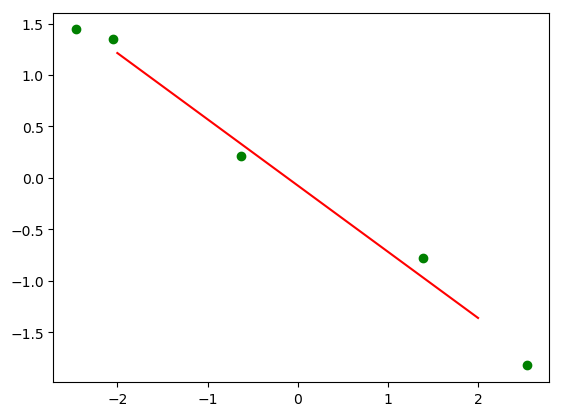

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1467ec908>

In [28]:
xx = [-2., 2.]
yy = aest .* xx .+ best
p_.plot(xx,yy,"r-")
p_.plot(x,y,"go")